In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

# loading the data

In [2]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [3]:
midwest=pd.read_csv('final data/midwest_stationary.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,23.0
2023-03-21,108.0
2023-03-22,-91.0
2023-03-23,192.0


In [4]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [5]:
west=pd.read_csv('final data/west_stationary.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,37.0
2023-03-21,-4.0
2023-03-22,151.0
2023-03-23,-95.0


# stationary analysis - ALL stationary

In [6]:
X = east.daily_deaths
result = adfuller(X)
print('East ADF Statistic: %f' % result[0])
print('East p-value: %f' % result[1])
print('East Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = midwest.daily_deaths
result = adfuller(X)
print('Midwest ADF Statistic: %f' % result[0])
print('Midwest p-value: %f' % result[1])
print('Midwest Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = south.daily_deaths
result = adfuller(X)
print('South ADF Statistic: %f' % result[0])
print('South p-value: %f' % result[1])
print('South Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = west.daily_deaths
result = adfuller(X)
print('West ADF Statistic: %f' % result[0])
print('West p-value: %f' % result[1])
print('West Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

East ADF Statistic: -3.842138
East p-value: 0.002504
East Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Midwest ADF Statistic: -6.612100
Midwest p-value: 0.000000
Midwest Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
South ADF Statistic: -3.104854
South p-value: 0.026196
South Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
West ADF Statistic: -5.691688
West p-value: 0.000001
West Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Visualizing the Data

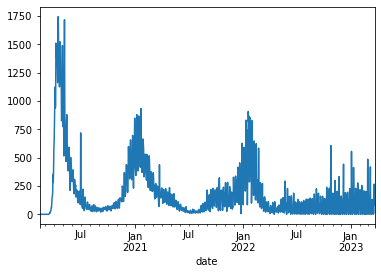

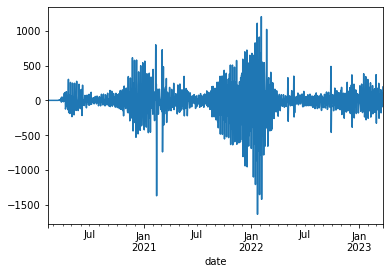

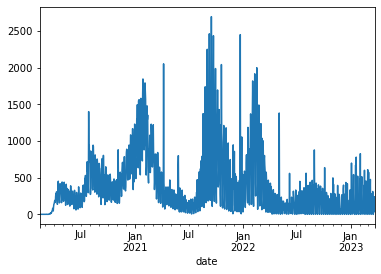

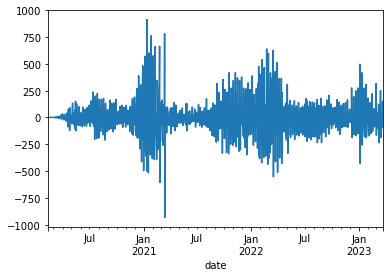

In [9]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [6]:
easttrain = east[east.index < '2023-01-01']
easttest = east[east.index >= '2023-01-01']
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < '2023-01-01']
midwesttest = midwest[midwest.index >= '2023-01-01']
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < '2023-01-01']
southtest = south[south.index >= '2023-01-01']
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < '2023-01-01']
westtest = west[west.index >= '2023-01-01']
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Visualizing data again

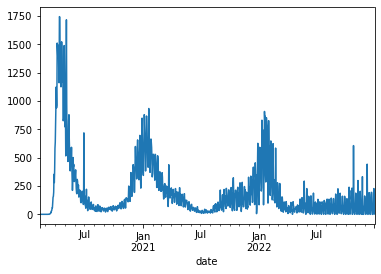

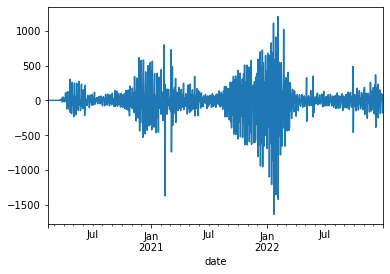

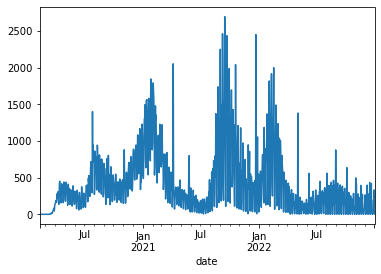

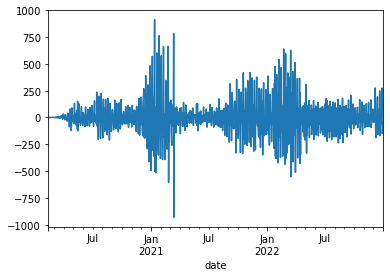

In [12]:
easttrain['daily_deaths'].plot()
plt.show()

midwesttrain['daily_deaths'].plot()
plt.show()

southtrain['daily_deaths'].plot()
plt.show()

westtrain['daily_deaths'].plot()
plt.show()

## plotting ACF and PACF
- For AR models & its order (p): the ACF will dampen exponentially.
    - The PACF will identify the order of the AR model:
    - The AR(1) model would have one significant spike at lag 1 on the PACF.
    - The AR(3) model would have significant spikes on the PACF at lags 1, 2, & 3.
    
- For MA models & its order (q): The PACF will dampen exponentially.
    - The ACF will be used to identify the order of the MA process.
    - The MA(1) has one significant spike in the ACF at lag 1.
    - The MA(3) has three significant spikes in the ACF at lags 1, 2, & 3
    
Based on the plots below:
- AR model (p): we need
    - the ACF does in fact dampen exponentially
    - the PACF demonstrates this would be AR(3)
- MA model: we may not need
    - the PACF doesn't exactly dampen exponentially
    - the ACF has one significant spike at lag 1 so MA(1)


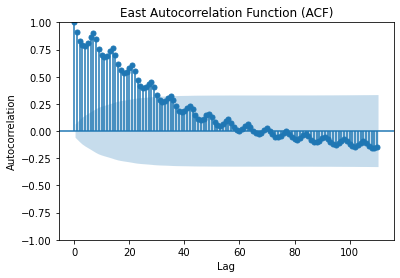

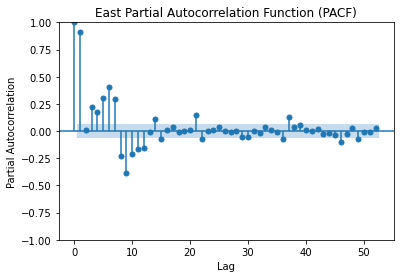

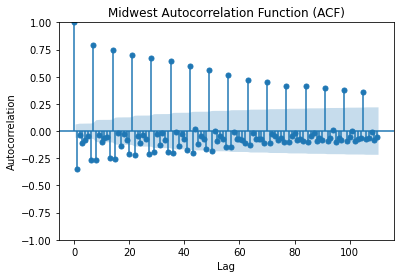

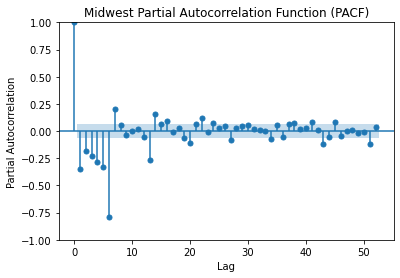

In [54]:
plot_acf(easttrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('East Autocorrelation Function (ACF)')
plt.show()

plot_pacf(easttrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('East Partial Autocorrelation Function (PACF)')
plt.show()

plot_acf(midwesttrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Midwest Autocorrelation Function (ACF)')
plt.show()

plot_pacf(midwesttrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Midwest Partial Autocorrelation Function (PACF)')
plt.show()

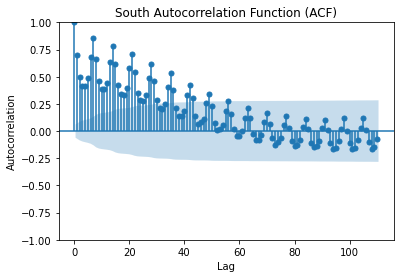

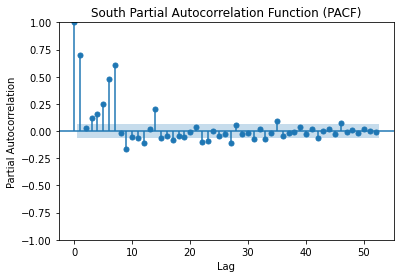

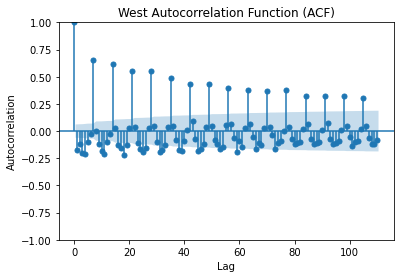

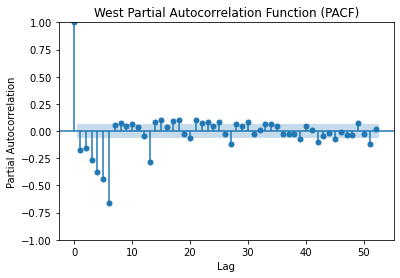

In [55]:
plot_acf(southtrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('South Autocorrelation Function (ACF)')
plt.show()

plot_pacf(southtrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('South Partial Autocorrelation Function (PACF)')
plt.show()

plot_acf(westtrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('West Autocorrelation Function (ACF)')
plt.show()

plot_pacf(westtrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('West Partial Autocorrelation Function (PACF)')
plt.show()

# Building the ARIMA
- so according to ACF and PACF plots we will need p = 3 and q = 1 or 0

### grid search p and q
- according to grid search p = 4 and q = 4 result in the lowest aic for east and midwest
- p = 3 and q = 4 for south
- p = 4 and q = 3 for west

- building out the models and testing (1) p = 4, q= 4 , (2) p = 3, q = 4, and (3) p = 4, q = 3 i found that the overall combined MAE is lower for (1)
    - combined MAE = 278 for (1), 281 for (2), and 294 for (3)

In [ ]:
# East

In [28]:
results=[]
for p in range(1,7):
    for q in range(1,7):
        model=ARIMA(easttrain['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
29,5,6,12164.003855
35,6,6,12203.002561
23,4,6,12203.832553
34,6,5,12206.069269
33,6,4,12208.256325
28,5,5,12228.812126
27,5,4,12235.187134
22,4,5,12243.794242
21,4,4,12244.667484
11,2,6,12252.998038


In [25]:
results=[]
for p in range(1,6):
    for q in range(1,6):
        model=ARIMA(easttrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,5,5,12254.041289
19,4,5,12266.673277
14,3,5,12269.272863
23,5,4,12269.486071
18,4,4,12386.428461
12,3,3,12393.592764
13,3,4,12396.975226
21,5,2,12403.614950
16,4,2,12438.885701
17,4,3,12452.957164


In [49]:
results=[]
for p in range(2,7):
    for q in range(2,7):
        model=ARIMA(easttrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,6,6,12167.251806
19,5,6,12216.466244
23,6,5,12242.482399
18,5,5,12254.041289
13,4,5,12266.673277
8,3,5,12269.272863
17,5,4,12269.486071
9,3,6,12271.131886
14,4,6,12271.314866
22,6,4,12323.648661


In [ ]:
# Midwest

In [15]:
results=[]
for p in range(0,4):
    for q in range(0,4):
        model=ARIMA(midwesttrain['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,3,3,12875.225487
11,2,3,12906.434957
7,1,3,13084.460818
3,0,3,13097.234218
10,2,2,13100.861295
14,3,2,13101.542110
13,3,1,13103.113277
9,2,1,13105.209942
6,1,2,13117.620110
2,0,2,13152.172722


In [47]:
results=[]
for p in range(2,7):
    for q in range(2,7):
        model=ARIMA(midwesttrain['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,6,6,12570.231669
21,6,3,12570.372876
22,6,4,12570.638801
23,6,5,12572.397261
20,6,2,12572.452186
19,5,6,12777.138592
4,2,6,12788.503188
8,3,5,12851.102248
17,5,4,12867.135008
16,5,3,12869.789060


In [ ]:
# South

In [41]:
results=[]
for p in range(1,7):
    for q in range(1,7):
        model=ARIMA(southtrain['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
35,6,6,14102.641495
34,6,5,14112.294595
33,6,4,14117.703403
31,6,2,14152.310671
32,6,3,14153.780607
29,5,6,14166.471435
30,6,1,14168.274546
28,5,5,14171.715793
27,5,4,14209.205249
23,4,6,14229.872016


In [42]:
results=[]
for p in range(1,7):
    for q in range(1,7):
        model=ARIMA(southtrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
35,6,6,14180.495972
34,6,5,14180.618668
33,6,4,14224.199442
29,5,6,14238.795949
28,5,5,14267.471881
31,6,2,14323.603643
27,5,4,14360.286661
22,4,5,14389.418912
16,3,5,14399.109554
23,4,6,14400.313381


In [ ]:
# West

In [48]:
results=[]
for p in range(1,7):
    for q in range(1,7):
        model=ARIMA(westtrain['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
35,6,6,12535.315860
34,6,5,12543.229873
32,6,3,12547.832649
33,6,4,12549.749409
30,6,1,12553.550632
31,6,2,12590.805123
25,5,2,12863.916482
27,5,4,12871.755875
26,5,3,13011.585737
29,5,6,13027.055708


In [49]:
results=[]
for p in range(1,7):
    for q in range(1,7):
        model=ARIMA(westtrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
35,6,6,12501.012325
34,6,5,12518.281841
33,6,4,12531.248599
31,6,2,12548.712117
32,6,3,12549.082951
30,6,1,12551.946402
29,5,6,12648.536813
28,5,5,12658.128101
25,5,2,12692.173765
11,2,6,12710.613302


## defining a function of MASE

In [8]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

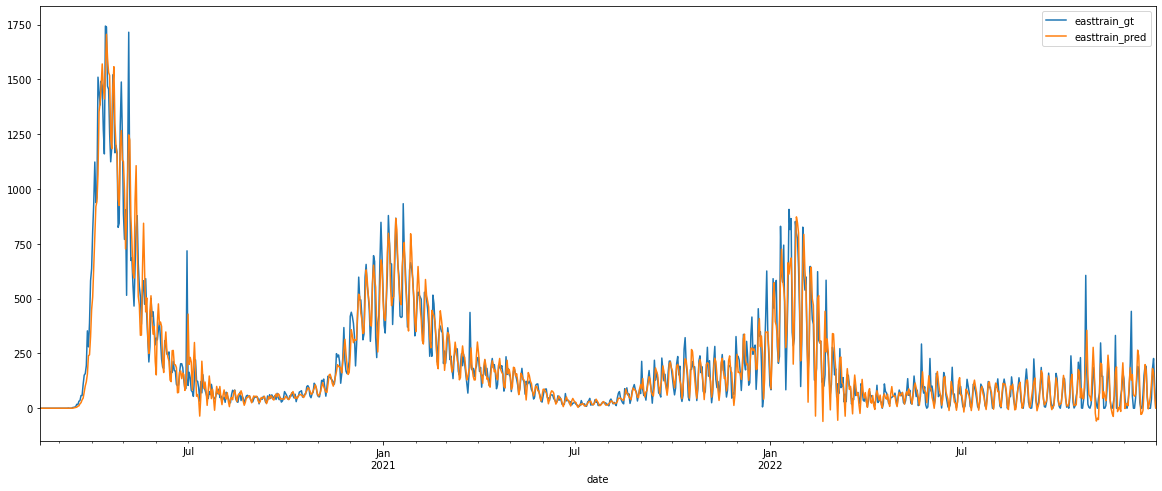

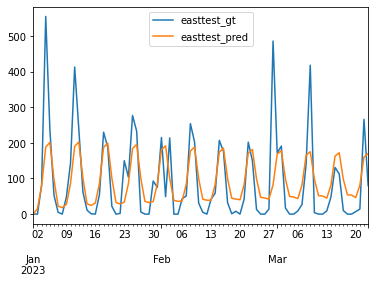

Training Set Metrics:
MAE: 45.247575400384626
MASE: 0.6913890977987465

Testing Set Metrics:
MAE: 57.146322303012575
MASE: 0.5981974808146833


In [23]:
emodel = ARIMA(easttrain['daily_deaths'], order=(5, 1, 6))
emodel=emodel.fit()

easttrain_pred=emodel.fittedvalues
pd.concat([easttrain, easttrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['easttrain_gt', 'easttrain_pred'])
plt.show()

easttest_pred=emodel.predict(start=len(easttrain), end=len(easttrain)+len(easttest)-1, dynamic=True)
pd.concat([easttest, easttest_pred], axis=1).plot()
plt.legend(['easttest_gt', 'easttest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(easttrain, easttrain_pred)
mase_train = MASE(easttrain, easttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(easttest, easttest_pred)
mase_test = MASE(easttest, easttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

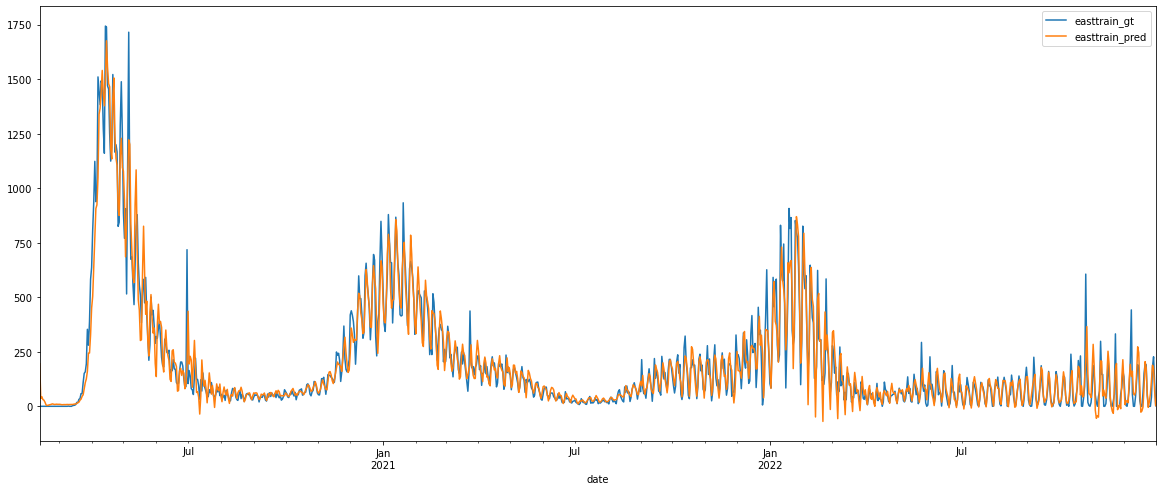

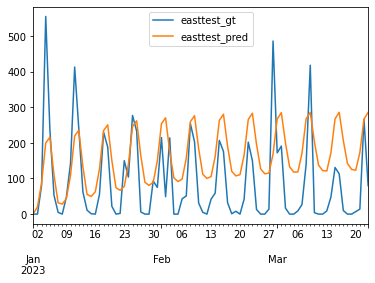

Training Set Metrics:
MAE: 45.791083901312625
MASE: 0.6996939815141149

Testing Set Metrics:
MAE: 98.97349776646095
MASE: 1.0360368724584308


In [9]:
emodel = ARIMA(easttrain['daily_deaths'], order=(6, 0, 6))
emodel=emodel.fit()

easttrain_pred=emodel.fittedvalues
pd.concat([easttrain, easttrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['easttrain_gt', 'easttrain_pred'])
plt.show()

easttest_pred=emodel.predict(start=len(easttrain), end=len(easttrain)+len(easttest)-1, dynamic=True)
pd.concat([easttest, easttest_pred], axis=1).plot()
plt.legend(['easttest_gt', 'easttest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(easttrain, easttrain_pred)
mase_train = MASE(easttrain, easttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(easttest, easttest_pred)
mase_test = MASE(easttest, easttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

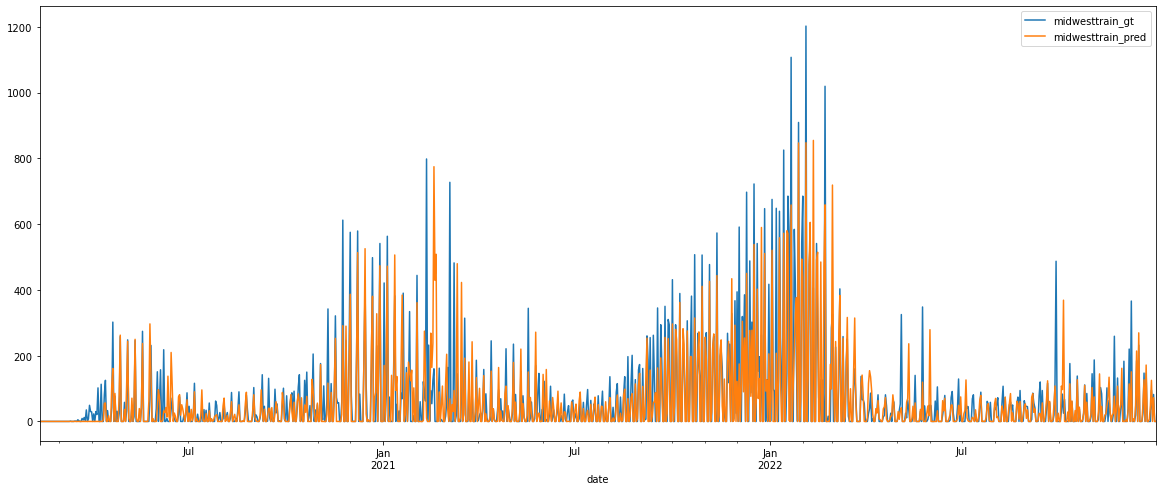

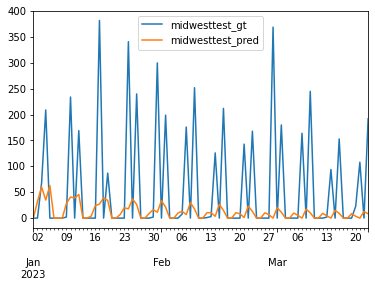

Training Set Metrics:
MAE: 40.473900626459994
MASE: 0.3835404729991214

Testing Set Metrics:
MAE: 61.101035105444694
MASE: 0.5325138630881235


In [45]:
mmodel = ARIMA(midwesttrain['daily_deaths'], order=(6, 1, 6))
mmodel=mmodel.fit()

midwesttrain_pred=mmodel.fittedvalues

# Clip negative predictions to zero in the training set
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
midwesttrain = np.maximum(midwesttrain, 0)

pd.concat([midwesttrain, midwesttrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['midwesttrain_gt', 'midwesttrain_pred'])
plt.show()

midwesttest_pred=mmodel.predict(start=len(midwesttrain), end=len(midwesttrain)+len(midwesttest)-1, dynamic=True)

# Clip negative predictions to zero in the testing set
midwesttest_pred = np.maximum(midwesttest_pred, 0)
midwesttest = np.maximum(midwesttest, 0)

pd.concat([midwesttest, midwesttest_pred], axis=1).plot()
plt.legend(['midwesttest_gt', 'midwesttest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(midwesttrain, midwesttrain_pred)
mase_train = MASE(midwesttrain, midwesttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(midwesttest, midwesttest_pred)
mase_test = MASE(midwesttest, midwesttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [48]:
mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -6508.052
Date:                Sat, 02 Mar 2024   AIC                          13042.103
Time:                        13:49:39   BIC                          13106.575
Sample:                    02-12-2020   HQIC                         13066.546
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9220      0.021    -44.769      0.000      -0.962      -0.882
ar.L2         -0.9440      0.017    -55.968      0.000      -0.977      -0.911
ar.L3         -0.9058      0.022    -41.095      0.000      -0.949      -0.863
ar.L4         -0.8415      0.020    -41.883      0.000      -0.881      -0.802
ar.L5         -0.8835      0.017    -50.521      0.000      -0.918      -0.849
ar.L6         -0.8114      0.012    -66.397      0.000      -0.835      -0.787
ma.L1         -0.7922      0.037    -21.229      0.000      -0.865      -0.719
ma.L2          0.0649      0.041      1.601      0.109      -0.015       0.144
ma.L3         -0.2868      0.040     -7.257      0.000      -0.364      -0.209
ma.L4         -0.0483      0.042     -1.159      0.247      -0.130       0.033
ma.L5          0.2047      0.044      4.641      0.000       0.118       0.291
ma.L6         -0.1414      0.038     -3.684      0.000      -0.217      -0.066
sigma2      1.572e+04    556.318     28.262      0.000    1.46e+04    1.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4017.62
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

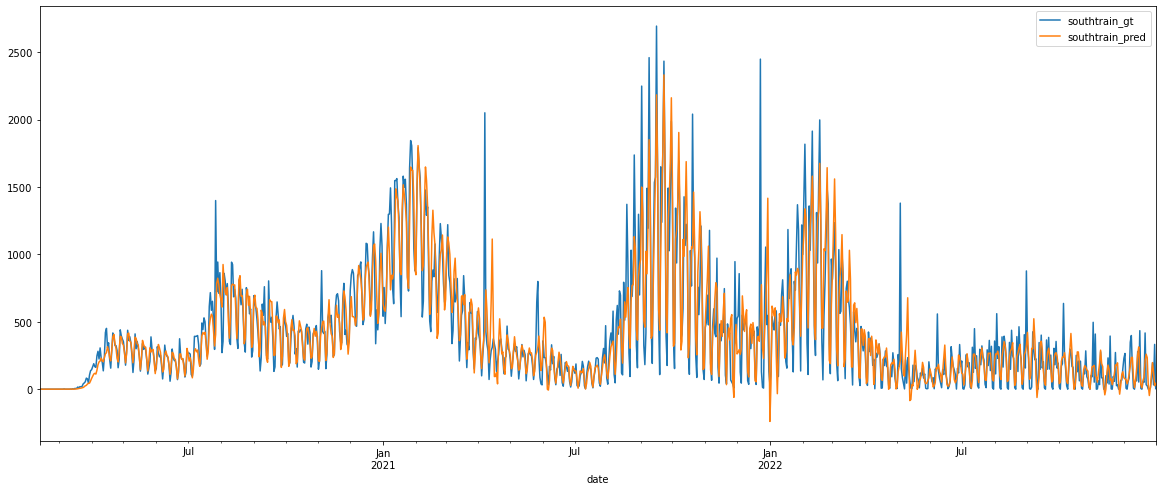

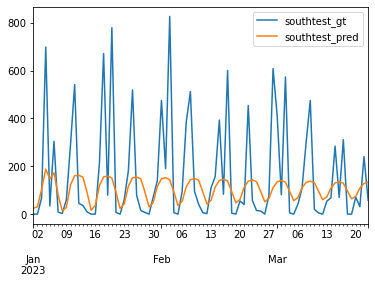

Training Set Metrics:
MAE: 115.02761629832636
MASE: 0.56754388084481

Testing Set Metrics:
MAE: 135.6539237391793
MASE: 0.6280992238981093


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Assuming you have defined the MASE function somewhere in your code

# Fit the ARIMA model to the training data
smodel = ARIMA(southtrain['daily_deaths'], order=(6, 1, 6))
smodel = smodel.fit()

# Get the fitted values for the training set
southtrain_pred = smodel.fittedvalues

# Plot the training set predictions against the actual values
pd.concat([southtrain, southtrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['southtrain_gt', 'southtrain_pred'])
plt.show()

# Use .forecast for test set predictions
forecast_steps = len(southtest)
southtest_pred = smodel.forecast(steps=forecast_steps)

# Create a time index for the test set predictions
time_index = pd.date_range(start=southtest.index[0], periods=forecast_steps, freq=southtest.index.freq)

# Create a DataFrame for the test set predictions
southtest_pred_df = pd.DataFrame(index=time_index, data={'daily_deaths_pred': southtest_pred})

# Plot the test set predictions against the actual values
pd.concat([southtest, southtest_pred_df], axis=1).plot()
plt.legend(['southtest_gt', 'southtest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(southtrain, southtrain_pred)
mase_train = MASE(southtrain, southtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate MAE for the testing set
mae_test = mean_absolute_error(southtest, southtest_pred_df['daily_deaths_pred'])
mase_test = MASE(southtest, southtest_pred_df['daily_deaths_pred'])

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)


In [31]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -7038.321
Date:                Sat, 02 Mar 2024   AIC                          14102.641
Time:                        11:32:04   BIC                          14167.114
Sample:                    02-12-2020   HQIC                         14127.084
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4816      0.070     -6.894      0.000      -0.619      -0.345
ar.L2         -0.8397      0.049    -17.281      0.000      -0.935      -0.744
ar.L3         -0.6646      0.087     -7.639      0.000      -0.835      -0.494
ar.L4         -0.6022      0.049    -12.384      0.000      -0.697      -0.507
ar.L5         -0.8634      0.059    -14.674      0.000      -0.979      -0.748
ar.L6         -0.4209      0.030    -13.868      0.000      -0.480      -0.361
ma.L1         -0.3411      0.073     -4.699      0.000      -0.483      -0.199
ma.L2          0.4241      0.100      4.245      0.000       0.228       0.620
ma.L3         -0.0585      0.116     -0.505      0.614      -0.286       0.169
ma.L4         -0.0174      0.108     -0.161      0.872      -0.229       0.195
ma.L5          0.3615      0.084      4.319      0.000       0.197       0.526
ma.L6         -0.2123      0.052     -4.080      0.000      -0.314      -0.110
sigma2      3.865e+04    615.898     62.758      0.000    3.74e+04    3.99e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             15763.87
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

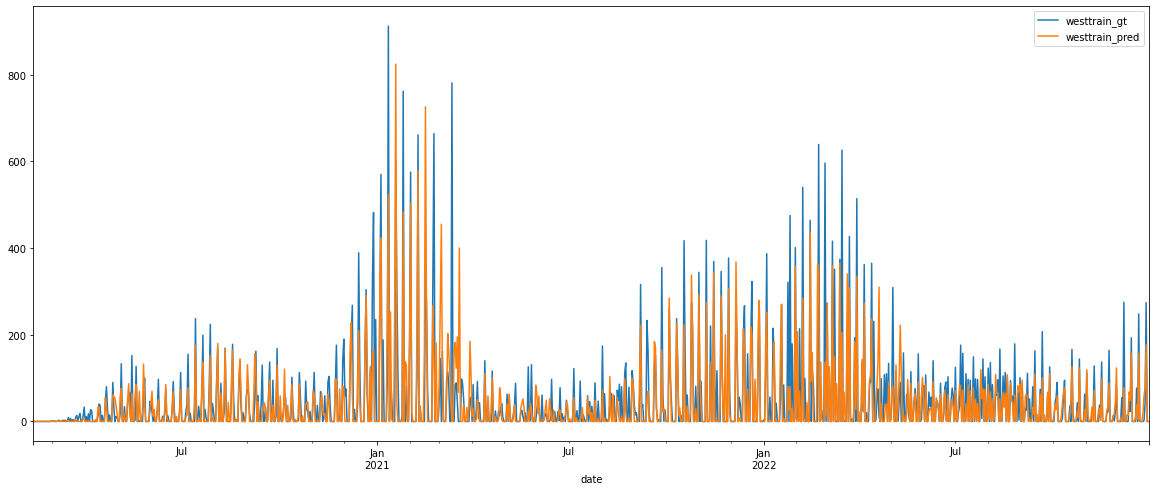

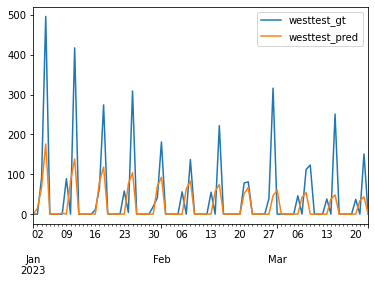

Training Set Metrics:
MAE: 29.30641997174142
MASE: 0.37240436644997604

Testing Set Metrics:
MAE: 37.028358302659015
MASE: 0.4499395473320403


In [37]:
wmodel = ARIMA(westtrain['daily_deaths'], order=(6, 1, 6))
wmodel=wmodel.fit()

westtrain_pred=wmodel.fittedvalues

# Clip negative predictions to zero in the training set
westtrain_pred = np.maximum(westtrain_pred, 0)
westtrain = np.maximum(westtrain, 0)

pd.concat([westtrain, westtrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['westtrain_gt', 'westtrain_pred'])
plt.show()

westtest_pred=wmodel.predict(start=len(westtrain), end=len(westtrain)+len(westtest)-1, dynamic=True)

# Clip negative predictions to zero in the testing set
westtest_pred = np.maximum(westtest_pred, 0)
westtest = np.maximum(westtest, 0)

pd.concat([westtest, westtest_pred], axis=1).plot()
plt.legend(['westtest_gt', 'westtest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(westtrain, westtrain_pred)
mase_train = MASE(westtrain, westtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(westtest, westtest_pred)
mase_test = MASE(westtest, westtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [38]:
wmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -6254.658
Date:                Sat, 02 Mar 2024   AIC                          12535.316
Time:                        11:36:09   BIC                          12599.788
Sample:                    02-12-2020   HQIC                         12559.758
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7351      0.032    -22.728      0.000      -0.798      -0.672
ar.L2         -0.8949      0.021    -43.002      0.000      -0.936      -0.854
ar.L3         -0.7899      0.032    -24.949      0.000      -0.852      -0.728
ar.L4         -0.7733      0.025    -30.333      0.000      -0.823      -0.723
ar.L5         -0.8785      0.023    -38.001      0.000      -0.924      -0.833
ar.L6         -0.6736      0.019    -35.985      0.000      -0.710      -0.637
ma.L1         -0.9912      0.042    -23.652      0.000      -1.073      -0.909
ma.L2          0.3519      0.064      5.484      0.000       0.226       0.478
ma.L3         -0.3347      0.073     -4.604      0.000      -0.477      -0.192
ma.L4          0.0456      0.070      0.654      0.513      -0.091       0.182
ma.L5          0.2587      0.060      4.280      0.000       0.140       0.377
ma.L6         -0.3246      0.034     -9.492      0.000      -0.392      -0.258
sigma2      9937.8406    226.009     43.971      0.000    9494.871    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              7552.95
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.71
Prob(H) (two-sided):                  0.41   Kurtosis:                        16.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""